In [1]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
import zipfile
import folium
import geojson

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from descartes import PolygonPatch
from shapely.geometry import Point
from shapely.ops import cascaded_union

In [2]:
cb_geo_json_link =  'https://raw.githubusercontent.com/missinglink/uk-postcode-polygons/master/geojson/CB.geojson'
cam_postcode_shapefile_r = urllib.request.urlopen(cb_geo_json_link)
cam_postcode_shapefile = geojson.loads(cam_postcode_shapefile_r.read())

In [3]:
central_list = []
postcodes = ["CB1", "CB2", "CB3", "CB4", "CB5"]
for numbers in range(0,16):
    if cam_postcode_shapefile['features'][numbers]['properties']['name'] in postcodes:
        data_1 = [cam_postcode_shapefile['features'][numbers]['properties']['name'],1]
        central_list.append(data_1)
    else:
        data_1 = [cam_postcode_shapefile['features'][numbers]['properties']['name'],0]
        central_list.append(data_1)
post_code_df = pd.DataFrame(central_list, columns = ['Postcode', 'Central Cambridge'])
post_code_df['Postcode'] = post_code_df['Postcode'].astype(str)

In [4]:
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                           'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.5, 
                                 'weight': 0.1}


frame = folium.Figure(width=500, height=500)
cambridge_map = folium.Map(
    location=[52.21, 0.15],
    tiles="cartodbpositron",
    zoom_start=9).add_to(frame)
chloro = folium.Choropleth(
    geo_data= cam_postcode_shapefile,
    data=post_code_df,
    name = 'Cambridge Postcodes',
    columns= ['Postcode', 'Central Cambridge'],
    key_on='feature.properties.name',
    fill_color="RdBu",
    fill_opacity=0.7,
    line_opacity=1,
    highlight = True,
   )
data_on_hover = folium.features.GeoJson(data = cam_postcode_shapefile, style_function=style_function, control=False, highlight_function=highlight_function, tooltip=folium.features.GeoJsonTooltip(
    fields= ['name'], 
    aliases=['Postcode: '],
    localize = True))

for key in chloro._children:
    if key.startswith('color_map'):
        del(chloro._children[key])

cambridge_map.add_child(data_on_hover)
cambridge_map.keep_in_front(data_on_hover)
chloro.add_to(cambridge_map)
folium.LayerControl().add_to(cambridge_map)
cambridge_map.save("images/folium/cambridge_postcode_map.html", "w")

In [5]:
# EPRACCUR GP Practice data ingestion
#-----------------------------------------

url = 'https://files.digital.nhs.uk/assets/ods/current/epraccur.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
first_file = zip_file_object.namelist()[0]
file = zip_file_object.open(first_file)
content = file.read()
csv_file = open('data/epraccur_data.csv', 'wb')
csv_file.write(content)
csv_file.close()
header_list = ["Organisation Code", "Name", "National Grouping", "High Level Health Geography", "Address line 1", "Address line 2", "Address line 3", 
"Address line 4", "Address line 5","Postcode","Open Date","Close Date","Status Code","Organisation Sub-Type Code","Commissioner","Join Provider/Purchaser Date",
"Left Provider/Purchaser Date","Contact Telephone Number", "Null 1", "Null 2", "Null 3", "Amended Record Indicator", "Null 4", "Provider/Purchaser",
"Null 5", "Prescribing Setting", "Null 6"]

# GP Practice Data Processing
#-----------------------------------------
gp_practice_df = pd.read_csv('data/epraccur_data.csv', names=header_list)
gp_practice_df = gp_practice_df[(gp_practice_df["Status Code"] == "A") & (gp_practice_df["Prescribing Setting"] == 4) #----------- Selecting only Active and Standard GP Practices form the data
& (gp_practice_df["Postcode"].str.contains('CB1 |CB2 |CB3 |CB4 |CB5 '))].reset_index(drop = True) #----------- Central cambridge defined as having the following postcodes: CB1, CB2, CB3, CB4, CB5
gp_practice_df['Full Address'] = gp_practice_df[['Address line 2', 'Address line 3', 'Address line 4',]].astype(str).agg(', '.join, axis=1)
gp_practice_df['Full Address'] = gp_practice_df['Full Address'].str.title() + ', ' + gp_practice_df['Postcode']
gp_practice_df['Full Address'] = gp_practice_df['Full Address'].str.replace('Nan', '').str.replace(' ,', ' ')
gp_practice_df['Name'] = gp_practice_df['Name'].str.title()
gp_practice_df_1 = gp_practice_df[['Organisation Code', 'Name', 'Full Address', 'Postcode', 'Contact Telephone Number']]

In [6]:

# Geolocation of GP practices in Cambridge
#-----------------------------------------
gp_practice_df_saved = pd.read_csv('data/cambridge_gp_practices.csv', index_col = 0)
new_list = list(gp_practice_df_1['Organisation Code'])
saved_list = list(gp_practice_df_saved['Organisation Code'])
new_orgs = list(set(new_list) - (set(saved_list)))
if new_orgs:
    geolocator = Nominatim(user_agent="open_access_nhs")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    gp_practice_df_1["location"] = gp_practice_df_1["Postcode"].apply(geolocator.geocode)
    gp_practice_df_1["Point"] = gp_practice_df_1["location"].apply(lambda loc: tuple(loc.point) if loc else None)
    gp_practice_df_1[['Latitude', 'Longitude', 'Altitude']] = gp_practice_df_1['Point'].to_list()
    gp_practice_df_2 = gp_practice_df_1[["Organisation Code","Name", "Full Address", "Postcode", "Contact Telephone Number", "Latitude", "Longitude"]]
    gp_practice_df_2.to_csv('data/cambridge_gp_practices.csv')
else:
    gp_practice_df_2 = gp_practice_df_saved.copy()
    print('No new cambridge GP practices')

No new cambridge GP practices


In [7]:
# Map visulation of Cambridge GP practices
#-----------------------------------------
frame = folium.Figure(width=600, height=600)
folium_fig = folium.Map(
    location=[52.21, 0.15],
    tiles="cartodbpositron",
    zoom_start=12).add_to(frame)
for code, name, address, number, lat, lon in zip(gp_practice_df_2['Organisation Code'],
gp_practice_df_2['Name'],
gp_practice_df_2['Full Address'],
gp_practice_df_2['Contact Telephone Number'],
gp_practice_df_2['Latitude'],
gp_practice_df_2['Longitude']):
    folium.Marker(
        [lat, lon],
        popup = folium.Popup('<b>' + 'Name: ' + '</b>'  + str(name) + '<br>'
        '<b>' + 'GP Practice Code: ' + '</b>' + str(code) + '<br>'
        '<b>' + 'Address: ' + '</b>' + str(address) + '<br>'
        '<b>' + 'Telephone Number: ' + '</b>' + str(number) + '<br>',
        max_width=len(address)*20),
        icon=folium.Icon(color="darkblue", prefix='fa', icon="fa-medkit"),
        ).add_to(folium_fig)
chloro = folium.Choropleth(
    geo_data= cam_postcode_shapefile,
    data=post_code_df,
    name = 'Cambridge Postcodes',
    columns= ['Postcode', 'Central Cambridge'],
    key_on='feature.properties.name',
    fill_color="RdBu",
    fill_opacity=0.1,
    line_opacity=1,
   )
for key in chloro._children:
    if key.startswith('color_map'):
        del(chloro._children[key])
chloro.add_to(folium_fig)
folium_fig
folium.LayerControl().add_to(folium_fig)
folium_fig.save("images/folium/cambridge_map_no_travel.html", "w")

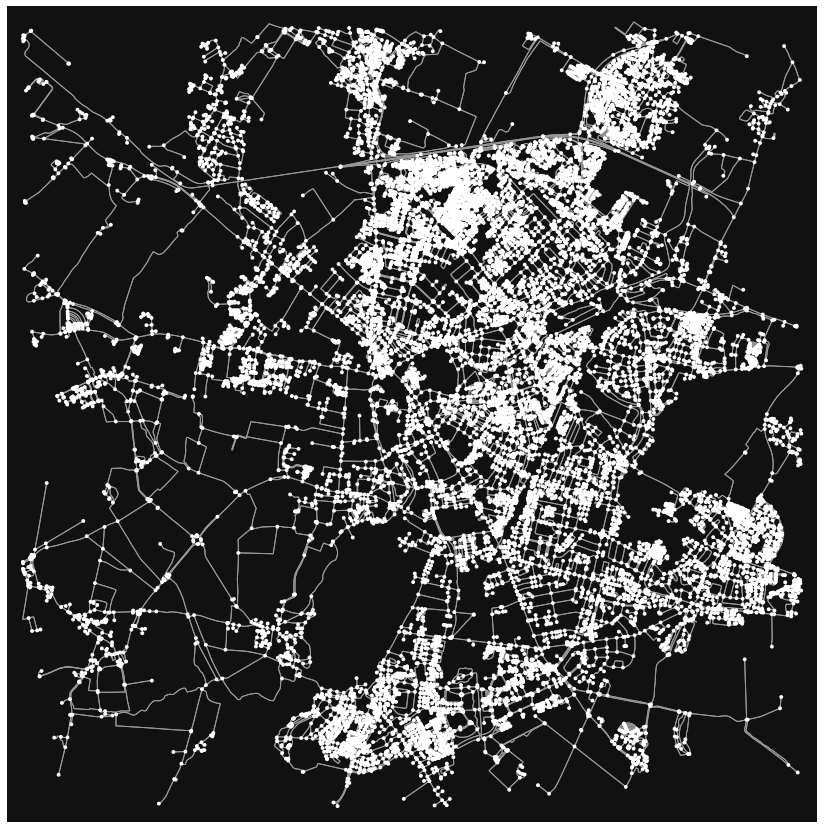

In [8]:
#Time of travel (walking) analysis for GP practices in central Cambridge (5000 meters from centre)
place = "Cambridge, England"
mode = "walk"
G = ox.graph_from_address(place, dist = 5000, simplify=True, network_type=mode)
fig, ax = ox.plot_graph(G, figsize = (15,15));

In [9]:

point_of_interest = ox.distance.nearest_nodes(G, X = gp_practice_df_2['Longitude'], Y=gp_practice_df_2['Latitude']) # X = longitude, Y = Latitude #------ nearest edge


In [10]:
# Trip time in Mintues
trip_times = [5,10,20]

# walking speed in km/hour
travel_speed = 4.5

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute


In [11]:
# 1 - get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='YlOrRd', start=0.3, return_hex=True)
# 2 - color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    for points in point_of_interest:
        subgraph = nx.ego_graph(G, points, radius=trip_time, distance='time')
        for node in subgraph.nodes():
            node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [10 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2, figsize = (15,15))

In [ ]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    isochrone_polys_sub = []
    for points in point_of_interest:
        subgraph = nx.ego_graph(G, points, radius=trip_time, distance='time')
        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
        isochrone_polys_sub.append(bounding_poly)
    isochrone_polys.append(isochrone_polys_sub)

In [ ]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none', figsize = (15,15))
for polygon, fc in zip(isochrone_polys, iso_colors):
    for subpolygon in polygon:
        patch = PolygonPatch(subpolygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
plt.show()

In [ ]:
style_geojson = [
{'shape_name': '20 min walk','shape_fillColor': '#003087'},
{'shape_name': '10 min walk', 'shape_fillColor': '#005EB8'},
{'shape_name': '5 min walk', 'shape_fillColor': '#41B6E6'}]
gdf_index = list(gp_practice_df_2.index)
for polygon, style in zip(isochrone_polys, style_geojson):
     gdf = gpd.GeoDataFrame({"GP Practice": gdf_index}, geometry= polygon)
     polygon_json = list(gdf['geometry'])
     geojson = gpd.GeoSeries(cascaded_union(polygon_json)).to_json()
     fillColor = style['shape_fillColor']
     shape_name = style['shape_name']
     folium.GeoJson(geojson, name = shape_name, style_function = lambda x, fillColor = fillColor: {
            "fillColor": fillColor,
            "name":  shape_name,
            "weight": 1,
            "fillOpacity": 0.5,
            "color": "#000000"
            }).add_to(folium_fig)

folium.LayerControl().add_to(folium_fig)
folium_fig
folium_fig.save("images/folium/cambridge_map_travel.html", "w")